In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from random import shuffle
from pprint import pprint
from copy import deepcopy
units_path = "/users/lijichen/work/polyscan/example/salamander/units/"
prep_config = {
    "typify": [
        {
            "name": "H",
            "charge": 0,
            "model_path": units_path + "H",
            "pdb": "H.pdb",
            "connect": "H",
        },
        {
            "name": "N",
            "charge": 1,
            "model_path": units_path + "N",
            "pdb": "N.pdb",
            "connect": "N",
        },
        {
            "name": "M",
            "charge": -1,
            "model_path": units_path + "M",
            "pdb": "M.pdb",
            "connect": "M",
        },
        {
            "name": "P",
            "charge": 0,
            "model_path": units_path + "P",
            "pdb": "P.pdb",
            "connect": "P",
        },
        {
            "name": "T",
            "charge": 0,
            "model_path": units_path + "T",
            "pdb": "T.pdb",
            "connect": "T",
        },
        {
            "name": "TFSI",
            "charge": -1,
            "model_path": units_path + "TFSI",
            "pdb": "TFSI.pdb"
        },
    ],
    "polymerize": {
        "backend": "molpy",
        "structs": [
        # {"name": "peo_15", "seq": ["H", *["P"] * 1, "T"]},
        # {"name": "LiTFSI", "ions": ["TFSI", "LI"]},
    ],},
    "pack": {
        "structs": [
            {"name": "peo_15", "box": 300, "number": 1},
            {"name": "LiTFSI", "box": 300, "number": 1},
        ]
    },
}

prep_configs = []
for n_pegm, n_mil in [(24, 0), (18, 6), (12, 12), (6, 18), (0, 24)]:
    for n_poly, nion in [(20, 0)]:
        config = deepcopy(prep_config)
        seq = ["N"] * n_mil + ["M"] * n_mil + ["P"] * n_pegm
        # shuffle(seq)
        config["polymerize"]["structs"].append({
            "name": f"MIL{n_mil}PEGM{n_pegm}", "seq": "H " + " ".join(seq) + " T"
        })
        config["polymerize"]["structs"].append({
            "name": f"LiTFSI", "ions": ["TFSI", "LI"]
        })
        config["pack"]["structs"][0]["name"] = f"MIL{n_mil}PEGM{n_pegm}"
        config["pack"]["structs"][1]["number"] = nion
        config["pack"]["structs"][0]["number"] = n_poly
        prep_configs.append(config)
        pprint([p['pack'] for p in prep_configs])
        print('00-0000')

md_eq_config = {
    "name": "md_eq",
    "stages": [
        {
            "type": "minimize",
        },
        {
            "type": "nve/limit",
            "steps": 1000e2,
        },
        {
            "type": "nvt",
            "Tstart": 400,
            "Tend": 400,
            "steps": 1000e3,
        },
        {
            "type": "npt",
            "Tstart": 400,
            "Tend": 400,
            "steps": 5000e3,
        },
        {
            "type": "npt",
            "Tstart": 400,
            "Tend": 1000,
            "steps": 2500e3,
        },
        {
            "type": "npt",
            "Tstart": 1000,
            "Tend": 550,
            "steps": 2500e3,
        },
        {"type": "npt", "Tstart": 550, "Tend": 50, "steps": 500 / 50 * 1e6},
    ]
}

process = [
    {"name": "prepare", "config": prep_config, "next": "md_eq"},
    {"name": "md_eq", "config": md_eq_config, "next": None},
]

[{'structs': [{'box': 300, 'name': 'MIL0PEGM24', 'number': 20},
              {'box': 300, 'name': 'LiTFSI', 'number': 0}]}]
00-0000
[{'structs': [{'box': 300, 'name': 'MIL0PEGM24', 'number': 20},
              {'box': 300, 'name': 'LiTFSI', 'number': 0}]},
 {'structs': [{'box': 300, 'name': 'MIL6PEGM18', 'number': 20},
              {'box': 300, 'name': 'LiTFSI', 'number': 0}]}]
00-0000
[{'structs': [{'box': 300, 'name': 'MIL0PEGM24', 'number': 20},
              {'box': 300, 'name': 'LiTFSI', 'number': 0}]},
 {'structs': [{'box': 300, 'name': 'MIL6PEGM18', 'number': 20},
              {'box': 300, 'name': 'LiTFSI', 'number': 0}]},
 {'structs': [{'box': 300, 'name': 'MIL12PEGM12', 'number': 20},
              {'box': 300, 'name': 'LiTFSI', 'number': 0}]}]
00-0000
[{'structs': [{'box': 300, 'name': 'MIL0PEGM24', 'number': 20},
              {'box': 300, 'name': 'LiTFSI', 'number': 0}]},
 {'structs': [{'box': 300, 'name': 'MIL6PEGM18', 'number': 20},
              {'box': 300, 'name': '

In [4]:
from burr.core import action, State, ApplicationBuilder
from burr.core.parallelism import MapStates
from h_submitor import submit
from pathlib import Path

@action(reads=["config"], writes=['prep_dir'])
def prepare_one(state: State):
    import molexp as me
    import polyscan.app
    from hamilton.execution.executors import SynchronousLocalTaskExecutor

    dr = me.Task("units").with_modules(polyscan.app).enable_dynamic_execution(allow_experimental_mode=True).with_local_executor(SynchronousLocalTaskExecutor()).build()

    result = dr.execute(["pack"], inputs={"config": state['prep_config']})
    return state.update(prep_dir=result['pack'])

@action(reads=['prep_dir'], writes=[])
@submit('slurm', 'slurm')
def md_eq(state: State, md_eq_config, proj_dir):
    import polyscan.eq_script
    prep_dir = state['prep_dir']
    config = deepcopy(md_eq_config)
    config['prep_dir'] = prep_dir
    this_dir = proj_dir / prep_dir.stem
    this_dir.mkdir(parents=True, exist_ok=True)
    polyscan.eq_script.write_md_script(this_dir, config)
    yield {
        'cmd': ['srun lmp -in md_eq.in'],
        "job_name": f'eq',
        "n_cores": 128,
        "run_time_max": '2-00:00:00',
        "account": 'project_465000925',
        "--partition": 'standard',
        "cwd": this_dir,
        "script_only": True
    }
    
    # submit('slurm', 'slurm')(foo)()
    return state

class Prepare(MapStates):

    def action(self, state, inputs):
        return prepare_one
    
    def states(self, state, context, inputs):
        for prep_config in inputs['prep_configs']:
            yield state.update(prep_config=prep_config)

    def reduce(self, state, states):
        prep_dirs = []
        for sub_state in states:
            prep_dirs.append(sub_state['prep_dir'])
        return state.update(prep_dirs=prep_dirs)
    
    @property
    def inputs(self):
        return super().inputs + ['prep_configs']
    
    @property
    def reads(self):
        return []
    
    @property
    def writes(self):
        return ['prep_dirs']
    
class Submit(MapStates):

    def action(self, state, inputs):
        return md_eq
    
    def states(self, state, context, inputs):
        for prep_dir in state['prep_dirs']:
            yield state.update(prep_dir=prep_dir)

    def reduce(self, state, states):
        return state
    
    @property
    def inputs(self):
        return super().inputs + ["md_eq_config", "proj_dir"]
    
    @property
    def reads(self):
        return ['prep_dirs']
    
    @property
    def writes(self):
        return []

app = ApplicationBuilder().with_actions(prepare = Prepare(), md_eq = Submit()).with_transitions(["prepare", "md_eq"]).with_entrypoint("prepare").build()

app.run(halt_after=["md_eq"], inputs={"prep_configs": prep_configs, "md_eq_config": md_eq_config, 'proj_dir': Path("salamander")})


-I: Adding /opt/conda/dat/leap/prep to search path.
-I: Adding /opt/conda/dat/leap/lib to search path.
-I: Adding /opt/conda/dat/leap/parm to search path.
-I: Adding /opt/conda/dat/leap/cmd to search path.
-f: Source tleap.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./tleap.in
----- Source: /opt/conda/dat/leap/cmd/leaprc.gaff
----- Source of /opt/conda/dat/leap/cmd/leaprc.gaff done
Log file: ./leap.log
Loading parameters: /opt/conda/dat/leap/parm/gaff.dat
Reading title:
AMBER General Force Field for organic molecules (Version 1.81, May 2017)
----- Source: /opt/conda/dat/leap/cmd/leaprc.water.tip3p
----- Source of /opt/conda/dat/leap/cmd/leaprc.water.tip3p done
Loading library: /opt/conda/dat/leap/lib/atomic_ions.lib
Loading library: /opt/conda/dat/leap/lib/solvents.lib
-I: Adding /opt/conda/dat/leap/prep to search path.
-I: Adding /opt/conda/dat/leap/lib to search path.
-I: Adding /opt/conda/dat/leap/parm to search path.
-I: Adding /opt/conda/dat/leap/cmd to search path.

(md_eq: prep_dirs -> {},
 {},
 {'__SEQUENCE_ID': 1, 'prep_dirs': [PosixPath('units/units/MIL0PEGM24_n20_LiTFSI_n0'), PosixPath('units/units/MIL6PEGM18_n20_LiTFSI_n0'), PosixPath('units/units/MIL12PEGM12_n20_LiTFSI_n0'), PosixPath('units/units/MIL18PEGM6_n20_LiTFSI_n0'), PosixPath('units/units/MIL24PEGM0_n20_LiTFSI_n0')], '__PRIOR_STEP': 'md_eq'})

In [3]:
import numpy as np
import matplotlib.pyplot as plt

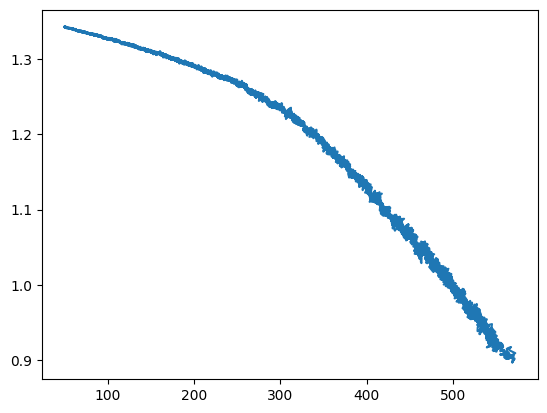

In [18]:
log = np.loadtxt('/users/lijichen/work/polyscan/example/salamander/salamander/MIL0PEGM24_n20_LiTFSI_n400/eq.thermo')
dens = log[:, 4]
T = log[:, 1]
step = np.arange(0, len(dens)* 1000, 1000)
plt.plot(T[int(1.1e4):], dens[int(1.1e4):])
# plt.ylim(0.6, 1.2)